In [3]:
from utils import get_data_jax, normalize, denormalize, make_dataset, create_data#, loss_fn
import jax.numpy as jnp
import pickle
import sys
sys.path.append('/home/honam/workspace/ode/pyur5/include/mbse')

import numpy as np
from mbse.utils.replay_buffer import ReplayBuffer, Transition
from models.ens_model import EnsembleModel
import jax
import os
import json
from utils import states2ind_states

In [4]:
fpath = '/home/honam/workspace/ode/pyur5/data/recording_robot_pole.txt'

In [5]:
ts = []
states = []
actions = []
with open(fpath, "r") as f:
    for line in f.readlines():
        data =json.loads(line)
        ts.append(data[0]["t"])
        states.append(data[1]['state'])
        actions.append(data[2]['input'])
ts = np.array(ts)
states = np.array(states)
actions = np.array(actions)
states = states[:,:,0]
actions = actions[:,0,0]

states, thetas, theta_dots, p_pivots, v_ees, p_balls, mocap_valids = states2ind_states(states)
mocap_valids = np.logical_and(mocap_valids[1:] == True, mocap_valids[:-1] == True)
mocap_valids = np.concatenate([mocap_valids, np.array([False])])
idx1 = actions != 0.0
idx_now = np.logical_and(idx1, mocap_valids)

idx_next = np.roll(idx_now, 1)
idx_next[0] = False


In [186]:
states_total = [thetas, theta_dots, p_pivots[:,0], v_ees[:,0]]

# reshape tensors
states_total = np.concatenate([np.expand_dims(state,-1) for state in states_total], 1)
actions = np.expand_dims(actions,-1)



ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 1

In [193]:
states = states_total[idx_now]
us = actions[idx_now]
ys = states_total[idx_next] - states_total[idx_now]
ys[:,0] = np.arctan2(np.sin(ys[:,0]), np.cos(ys[:,0]))
xs = np.concatenate([states, us], -1)
x_nexts = np.concatenate([states_total[idx_next], actions[idx_next]],-1)


In [118]:
np.savetxt("data", thetas[idx])

In [7]:
datas = get_data_jax(fpath)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[False False False ... False False False]
xs.shape:  (24063, 5)
ys.shape:  (24063, 4)
us.shape:  (24063, 1)
x_nexts.shape:  (24063, 5)


In [222]:
use_cos = False
train_horizon = 1

In [223]:
ts = []
states = []
actions = []
with open(fpath, "r") as f:
    for line in f.readlines():
        data =json.loads(line)
        ts.append(data[0]["t"])
        states.append(data[1]['state'])
        actions.append(data[2]['input'])
ts = np.array(ts)
states = np.array(states)
actions = np.array(actions)
states = states[:,:,0]
actions = actions[:,0,0]

states, thetas, theta_dots, p_pivots, v_ees, p_balls, mocap_valids = states2ind_states(states)
mocap_valids = np.logical_and(mocap_valids[train_horizon:] == True, mocap_valids[:-train_horizon] == True)
mocap_valids = np.concatenate([mocap_valids, np.array([False])])

idx1 = actions != 0.0
idx_now = np.logical_and(idx1, mocap_valids)

idx_next = np.roll(idx_now, train_horizon)
for i in range(train_horizon):
    idx_next[i] = False

print(idx_now)
if use_cos:
    states_total = [np.cos(thetas), np.sin(thetas), theta_dots, p_pivots[:,0], v_ees[:,0]]
else:
    states_total = [thetas, theta_dots, p_pivots[:,0], v_ees[:,0]]


[False False False ... False False False]


In [229]:
# reshape tensors
states_total = np.concatenate([jnp.expand_dims(state,-1) for state in states_total], 1)
actions = np.expand_dims(actions,-1)

states = states_total[idx_now]
us = actions[idx_now]
ys = states_total[idx_next] - states_total[idx_now]


In [230]:
states

array([[-3.0925758e+00,  6.1593704e-02, -1.3053004e-01,  0.0000000e+00],
       [-3.0925713e+00,  2.7601302e-04, -1.3135874e-01,  0.0000000e+00],
       [-3.0925362e+00,  2.1062836e-03, -1.3237917e-01,  0.0000000e+00],
       ...,
       [-7.2747391e-01,  5.5884147e+00,  3.6187954e-02,  3.8689804e-01],
       [-6.5762085e-01,  4.1911817e+00,  4.1029908e-02,  3.2417944e-01],
       [-5.4649913e-01,  6.6673026e+00,  4.5136821e-02,  2.5540578e-01]],
      dtype=float32)

In [6]:
def get_data_jax(fpath, moving_win=None, train_horizon=1, use_cos=False):
    '''
        retrieve data from json file
    '''
    ts = []
    states = []
    actions = []
    with open(fpath, "r") as f:
        for line in f.readlines():
            data =json.loads(line)
            ts.append(data[0]["t"])
            states.append(data[1]['state'])
            actions.append(data[2]['input'])
    ts = np.array(ts)
    states = np.array(states)
    actions = np.array(actions)
    states = states[:,:,0]
    actions = actions[:,0,0]

    states, thetas, theta_dots, p_pivots, v_ees, p_balls, mocap_valids = states2ind_states(states)
    mocap_valids = np.logical_and(mocap_valids[train_horizon:] == True, mocap_valids[:-train_horizon] == True)
    mocap_valids = np.concatenate([mocap_valids, np.array([False])])
    
    idx1 = actions != 0.0
    idx_now = np.logical_and(idx1, mocap_valids)

    idx_next = np.roll(idx_now, train_horizon)
    for i in range(train_horizon):
        idx_next[i] = False
    
    print(idx_now)
    if use_cos:
        states_total = [np.cos(thetas), np.sin(thetas), theta_dots, p_pivots[:,0], v_ees[:,0]]
    else:
        states_total = [thetas, theta_dots, p_pivots[:,0], v_ees[:,0]]

    # reshape tensors
    states_total = np.concatenate([jnp.expand_dims(state,-1) for state in states_total], 1)
    actions = np.expand_dims(actions,-1)

    states = states_total[idx_now]
    us = actions[idx_now]
    ys = states_total[idx_next] - states_total[idx_now]
    if not use_cos:
        ys[:,0] = np.arctan2(np.sin(ys[:,0]), np.cos(ys[:,0]))
    xs = np.concatenate([states, us], -1)
    x_nexts = np.concatenate([states_total[idx_next], actions[idx_next]],-1)
    # print((mocap_valids>0).sum())
    print("xs.shape: ", xs.shape)
    print("ys.shape: ", ys.shape)
    print("us.shape: ", us.shape)
    print("x_nexts.shape: ", x_nexts.shape)
    return states, xs, ys, us, ts, x_nexts

In [11]:
datas[3].min(0)

array([-1.])

In [15]:
action_max = 1.0
train_horizon = 1
use_cos = False

In [28]:
with open("/home/honam/workspace/ode/pyur5/data_pkl/data_pole_{}_{}_{}.pkl".format(action_max, train_horizon, use_cos), "rb") as f:
    data = pickle.load(f)

In [29]:
data['transitions']

KeyError: 'transitions'

In [22]:
import matplotlib.pyplot as plt

(array([ 610.,    0.,    0.,    0.,    0.,   89.,    0.,    0.,    0.,
           0.,   48.,    0.,    0.,    0.,    0.,   87.,    0.,    0.,
           0.,    0.,   89.,    0.,    0.,    0.,    0.,  106.,    0.,
           0.,    0.,    0.,   95.,    0.,    0.,    0.,  253.,    0.,
           0.,    0.,    0., 1833.,    0.,    0.,    0.,    0., 7602.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8220.,    0.,    0.,    0.,    0.,    0.,  923.,    0.,    0.,
           0.,  337.,    0.,    0.,    0.,    0.,  301.,    0.,    0.,
           0.,    0.,    0.,  304.,    0.,    0.,    0.,  237.,    0.,
           0.,    0.,    0.,    0.,  242.,    0.,    0.,    0.,    0.,
         186.,    0.,    0.,    0.,  307.,    0.,    0.,    0.,    0.,
        2194.]),
 array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
        -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
        -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.

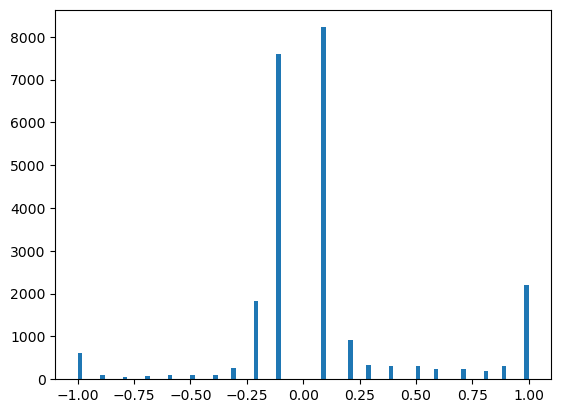

In [24]:
plt.hist(data['u'], bins=100)

In [46]:
import torch
import torch.nn as nn

class NCSNv2FN(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_feats = 64#config.in_feats
        self.act = nn.functional.gelu #config.act
         #config.norm
        
        self.enc1 = nn.Linear(self.in_feats, self.in_feats//2)
        self.norm1 = nn.LayerNorm(self.in_feats//2)
        self.enc2 = nn.Linear(self.in_feats//2, self.in_feats//4)
        self.norm2 = nn.LayerNorm(self.in_feats//4)
        self.enc3 = nn.Linear(self.in_feats//4, self.in_feats//8)
        self.norm3 = nn.LayerNorm(self.in_feats//8)
        self.enc4 = nn.Linear(self.in_feats//8, self.in_feats//16)
        self.norm4 = nn.LayerNorm(self.in_feats//16)

        self.dec5 = nn.Linear(self.in_feats//16, self.in_feats//16)
        self.norm5 = nn.LayerNorm(self.in_feats//16)

        self.dec6 = nn.Linear(self.in_feats//8, self.in_feats//8)
        self.norm6 = nn.LayerNorm(self.in_feats//8)
        
        self.dec7 = nn.Linear(self.in_feats//4, self.in_feats//4)
        self.norm7 = nn.LayerNorm(self.in_feats//4)
        
        self.dec8 = nn.Linear(self.in_feats//2, self.in_feats//2)
        self.norm8 = nn.LayerNorm(self.in_feats//2)
        
        self.dec9 = nn.Linear(self.in_feats, self.in_feats)

    def forward(self, x, sigma):
        
        layer1 = self.enc1(x) # (batch_size, in_feats//2)
        layer1 = self.act(layer1)
        layer1 = self.norm1(layer1)
        
        layer2 = self.enc2(layer1) # (batch_size, in_feats//4)
        layer2 = self.act(layer2)
        layer2 = self.norm2(layer2)
        
        layer3 = self.enc3(layer2) # (batch_size, in_feats//8)
        layer3 = self.act(layer3)
        layer3 = self.norm3(layer3)
        
        layer4 = self.enc4(layer3) # (batch_size, in_feats//16)
        layer4 = self.act(layer4)
        layer4 = self.norm4(layer4)
        
        layer5 = self.dec5(layer4) # (batch_size, in_feats//8)
        layer5 = self.act(layer5)
        layer5 = self.norm5(layer5)
        
        layer6 = self.dec6(torch.cat([layer5, layer4], dim=-1)) # (batch_size, in_feats//4)
        layer6 = self.act(layer6)
        layer6 = self.norm6(layer6)
        
        layer7 = self.dec7(torch.cat([layer6, layer3], dim=-1)) # (batch_size, in_feats//2)
        layer7 = self.act(layer7)
        layer7 = self.norm7(layer7)
        
        layer8 = self.dec8(torch.cat([layer7, layer2], dim=-1)) # (batch_size, in_feats)
        layer8 = self.act(layer8)
        layer8 = self.norm8(layer8)
        
        layer9 = self.dec9(torch.cat([layer8, layer1], dim=-1)) # (batch_size, in_feats)
        
        return layer8
    

In [47]:
scn = NCSNv2FN()

In [48]:
scn

NCSNv2FN(
  (enc1): Linear(in_features=64, out_features=32, bias=True)
  (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (enc2): Linear(in_features=32, out_features=16, bias=True)
  (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (enc3): Linear(in_features=16, out_features=8, bias=True)
  (norm3): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (enc4): Linear(in_features=8, out_features=4, bias=True)
  (norm4): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (dec5): Linear(in_features=4, out_features=4, bias=True)
  (norm5): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (dec6): Linear(in_features=8, out_features=8, bias=True)
  (norm6): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (dec7): Linear(in_features=16, out_features=16, bias=True)
  (norm7): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (dec8): Linear(in_features=32, out_features=32, bias=True)
  (norm8): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
 

In [49]:
x = torch.randn(128, 64)

In [51]:
scn(x)

TypeError: NCSNv2FN.forward() missing 1 required positional argument: 'y'